In [40]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [41]:
# Import relevant packages
from pathlib import Path
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.io import read_image
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

In [42]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

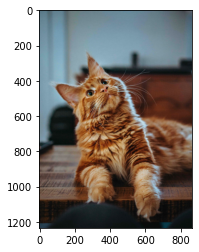

In [43]:
# Load the image
image = Image.open("./data/cat_image.jpg")
plt.imshow(image)
plt.show()

In [44]:
# Normalize our input image
transforms = T.Compose(
    [T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
input_image = transforms(image).unsqueeze(0)

In [45]:
# Check if gpu is available or use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the deeplab v3 model - set pre-trained = True
dlab_model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

In [46]:
# Get the model output
output = dlab_model(input_image)["out"]

In [8]:
# Check the output of the model is a tensor of shape (batch_size, num_classes, H, W)
print(output.shape)

torch.Size([1, 21, 1234, 867])


In [9]:
# Load in the pre-trained classes of the model
sem_classes = [
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [10]:
# Normalise the mask into a [0,1] range with softmax
normalized_masks = torch.nn.functional.softmax(output, dim=1)

In [11]:
# Let's check the classes
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

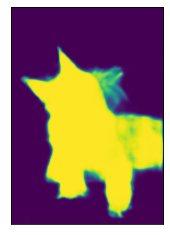

In [12]:
# Show the probability mask
probability_mask = normalized_masks[0, sem_class_to_idx["cat"]]
show(probability_mask.float())

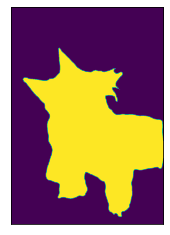

In [13]:
# Get a boolean mask for further plotting
class_dim = 1
boolean_mask = normalized_masks.argmax(class_dim) == sem_class_to_idx["cat"]
show(boolean_mask.float())

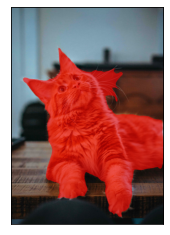

In [14]:
# Let's plot the mask over the original image
cat_int = read_image(str(Path("data") / "cat_image.jpg"))

overlaid_mask = draw_segmentation_masks(
    cat_int, masks=boolean_mask, alpha=0.6, colors="red"
)
show(overlaid_mask)